In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 1) Single uncertain variable

Model:

$ u = I\,e^{-a\,x} $ 

In [2]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)
I = 1.

with uncertain inputs: $a$

In [3]:
#cp.Uniform(lo=0, up=0.1)
#dist_a = cp.Normal(mu=0.08,sigma=0.02)
dist_a = cp.Weibull(shape=2., scale=0.1, shift=0)

### a) MC propagation

A full Monte-Carlo simulation of the inputs is done ussing a reduced variance sampling method.

"K"     Korobov             
"R"     (Pseudo-)Random     
"L"     Latin hypercube     
"S"     Sobol               
"H"     Halton              
"M"     Hammersley          

In [4]:
sample_a = dist_a.sample(size=1000,rule='L')

The input sample is propagated through the model

In [5]:
sample_u = np.array([u(x,a,I) for a in sample_a])

In [6]:
E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

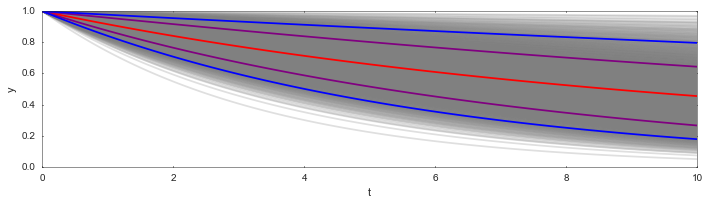

In [7]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')
ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/1_Weibull_MC.pdf')
print

### b) PCE with Pseudo-spectral collocation

In [8]:
M = 3    # Order of the polynomial
N = M + 1 # Number of terms, evaluations per dimension

Generation of the polynomial basis using the Stiltjes algorithm (three term recursive expression).

In [9]:
P = cp.orth_ttr(M, dist_a)

The polynomials are not normalized (this is not required)

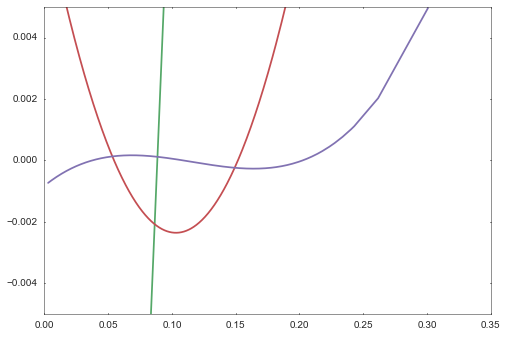

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
for p in P:
    ax.plot(np.sort(sample_a),p(np.sort(sample_a)))
#ax.set_xlim([0,2])
ax.set_ylim([-0.005,0.005])
print 

Pseudo-spectral collocation used based on Gaussian quadrature. Gaussian quadrature is a familly of quadratures that gives the nodes and weights of the integration scheme corresponding to the weighting pdf. 

In [11]:
nodes, weights = cp.generate_quadrature(M,dist_a,rule='G')
print 'nodes: ', nodes
sample_u_pc = np.array([u(x,*node,I=I) for node in nodes.T])

nodes:  [[ 0.02800995  0.08320771  0.15563899  0.24632849]]


The PCE is computed by projecting the model evaluations in the polynomial basis. 

This requires: 
* P: Polynomial basis
* nodes: location of model evaluations
* weights: weight corresponding to each node in the Gauss quadrature rule
* sample_u_pc: model evaluated at the nodes

In [12]:
u_hat_pc = cp.fit_quadrature(P,nodes,weights,sample_u_pc)

In [13]:
mean_u_pc, var_u_pc = cp.E(u_hat_pc, dist_a), cp.Var(u_hat_pc, dist_a),

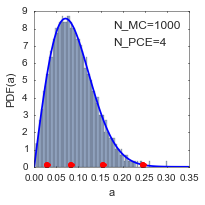

In [14]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

ax.hist(x=sample_a,bins=100,normed=True, alpha=0.5)
ax.plot(np.linspace(0,0.35,100), dist_a.pdf(np.linspace(0,0.35,100)), color='b')
ax.plot(nodes,0.1,'or')
ax.set_xlabel('a')
ax.set_ylabel('PDF(a)')
ax.set_xticks(np.linspace(0,0.35,8))
ax.text(0.18,8.,'N_MC=1000')
ax.text(0.18,7,'N_PCE=4')
fig.tight_layout()
fig.savefig('Figures/1_Weibull_MC_sample.pdf')
print

A full MC can be performed on the PCE surrogate

In [15]:
sample_u_hat = np.array([u_hat_pc(in_vars) for in_vars in sample_a.T ])

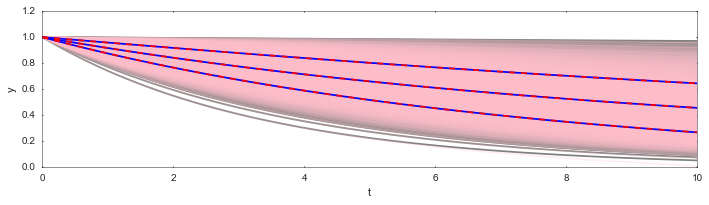

In [16]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+var_u_pc**.5,'--r')
ax.plot(x,mean_u_pc-var_u_pc**.5,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/1_Weibull_top.pdf')
print

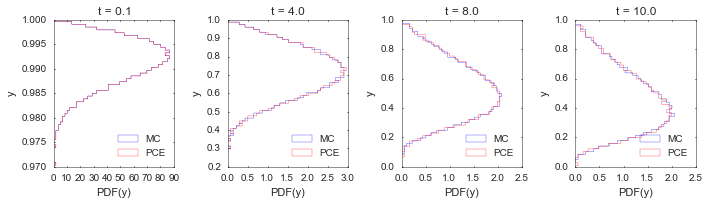

In [17]:
x_ref = 9.9

fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([.1, 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='lower right')

fig.tight_layout()    
fig.savefig('Figures/1_Weibull_bot.pdf')    
print

# 2) Multi-variable Normal

Model:

$ u = I\,e^{-a\,x} $ 

In [18]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

with uncertain inputs: $a$ and $I$

In [19]:
dist = cp.J(cp.Normal(0.05,0.02), cp.Normal(.95,.05))

### a) MC propagation

A full Monte-Carlo simulation of the inputs is done ussing a reduced variance sampling method.

"K"     Korobov             
"R"     (Pseudo-)Random     
"L"     Latin hypercube     
"S"     Sobol               
"H"     Halton              
"M"     Hammersley          

The input sample is propagated through the model

In [20]:
sample_inputs = dist.sample(size=1000,rule='L')
sample_u = np.array([u(x,*in_vars) for in_vars in sample_inputs.T ])

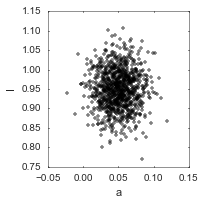

In [21]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('I')
ax.set_xticks(np.linspace(-0.05,0.15,5))

fig.tight_layout()
#fig.savefig('Figures/2_2xNormal_NoCorr_MC_sample.pdf')
print

In [22]:
E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

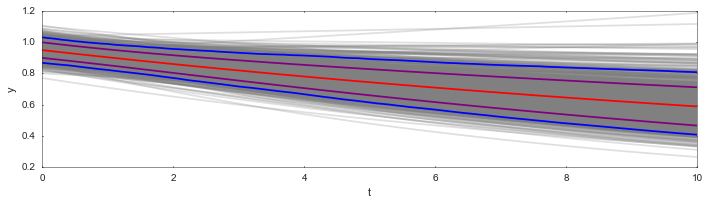

In [23]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_MC.pdf')
print

### b) PCE with Pseudo-spectral collocation

In [24]:
M = 2    # Order of the polynomial
N = M + 1 # Number of terms

Generation of the polynomial basis using the Stiltjes algorithm (three term recursive expression) and the quadrature rule. Pseudo-spectral collocation used based on Gaussian quadrature.

In [25]:
P = cp.orth_ttr(M, dist)
nodes, weights = cp.generate_quadrature(M, dist, rule='G')
print 'nodes'
print nodes

nodes
[[ 0.01535898  0.01535898  0.01535898  0.05        0.05        0.05
   0.08464102  0.08464102  0.08464102]
 [ 0.86339746  0.95        1.03660254  0.86339746  0.95        1.03660254
   0.86339746  0.95        1.03660254]]


The PCE is computed by projecting the model evaluations in the polynomial basis. 

This requires: 
* P: Polynomial basis
* nodes: location of model evaluations
* weights: weight corresponding to each node in the Gauss quadrature rule
* sample_u_pc: model evaluated at the nodes

In [26]:
samples_u_pc = [u(x,*node) for node in nodes.T]
u_hat = cp.fit_quadrature(P, nodes, weights, samples_u_pc)

In [27]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist), cp.Std(u_hat, dist)

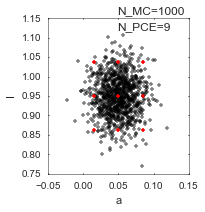

In [28]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.plot(nodes[0,:],nodes[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')
ax.set_xticks(np.linspace(-0.05,0.15,5))

ax.text(0.05,1.16,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.05,1.12,'N_PCE='+str(len(nodes[0,:])))

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_MC_sample.pdf')
print

Repeat the MC sample ussing the surrogate model


In [29]:
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_inputs.T ])

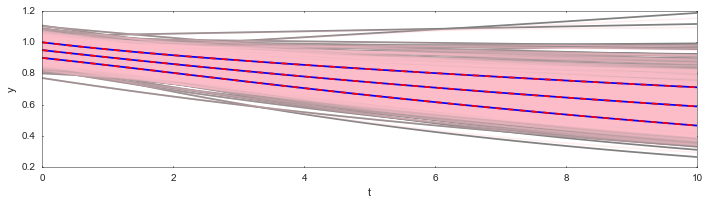

In [30]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_top.pdf')
print

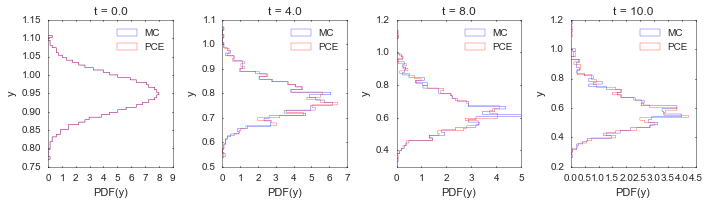

In [31]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_bot.pdf')
print

### Sensitivity analysis by variance decomposition (Sobol's indices)

In [32]:
Sensitivity = cp.Sens_t(u_hat, dist)

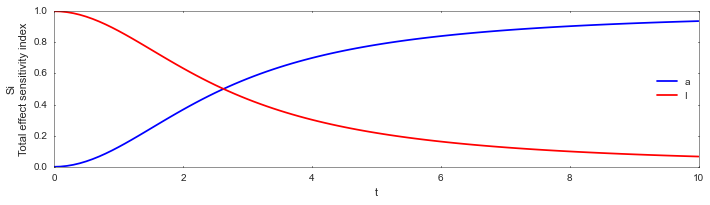

In [33]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/2_2xNormal_NoCorr_Sens.pdf')

# 3) Multivariate Normal

In [34]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

In [35]:
mu = [.8,8.] 
C = [[.01,.1],[.1,2.]]

dist_Q = cp.MvNormal(mu,C)
# Uncorrelated Standard Normals
dist_R = cp.J(cp.Normal(), cp.Normal())
# Cholesky decomposition: C=np.dot(L.T,L)
L = np.linalg.cholesky(C) 
# Transfromation to Standard Normal
def tr(r):
    return np.dot(L,r) + np.reshape(mu,[2,1])

### a) Full MC with Halton sampling

In [36]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

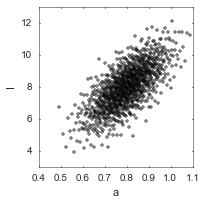

In [37]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
#fig.savefig('Figures/3_MultiNormal_MC_sample.pdf')
print

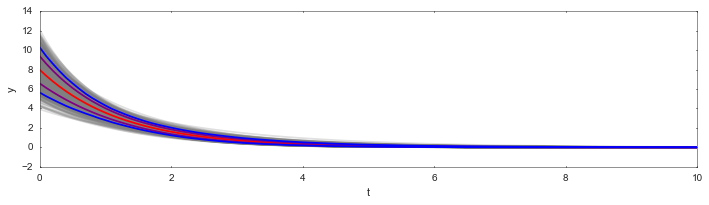

In [39]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_MC.pdf')
print

### b) PCE with Point collocation: Least squares

In [40]:
M = 4     # Order of the polynomial
N = M + 1 # Number of terms

In [41]:
P = cp.orth_ttr(M,dist_R)
# Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
# Exponenial rule 
nodes_R = dist_R.sample(2**M-1,rule='M') 
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))#tr(nodes_R)
sample_u_pc = np.array([u(x,*node) for node in nodes_Q.T])

print len(P)

u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)#, rule='LA', n_nonzero_coefs=20, eps=1e-3)

15


15


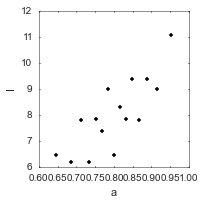

In [42]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

ax.plot(nodes_Q[0,:],nodes_Q[1,:],'.k')

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_PCE_sample.pdf')
print len(nodes_Q[0,:])

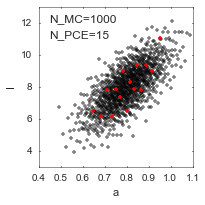

In [43]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.45,12,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.45,11,'N_PCE='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_MC_sample.pdf')
print

In [44]:
print u_hat[0]

q1+2.76012763278e-16q0q1^2+8.0+4.32772080083e-16q0^3-3.552790817e-15q0^3q1+1.11042340265e-15q0^2q1+2.31237627162e-14q1^2+1.13851857722e-14q0^2-2.50261579287e-15q0q1^3+3.88578058619e-15q0^2q1^2-5.295406541e-15q1^4+q0-1.79936490849e-15q1^3+7.9503675871e-15q0q1+8.23245346988e-16q0^4


In [45]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

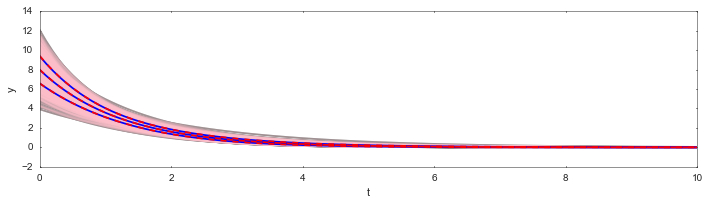

In [46]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_top.pdf')
print

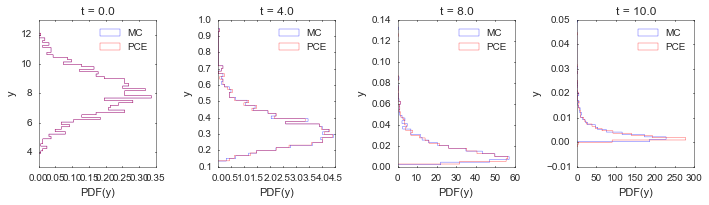

In [47]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_bot.pdf')
print

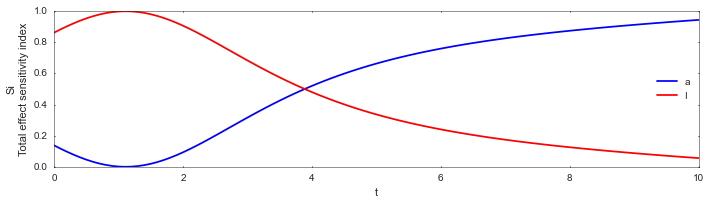

In [48]:
Sensitivity = cp.Sens_t(u_hat, dist)

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_Sens.pdf')


### c) PCE with Semi-spectral projection

81


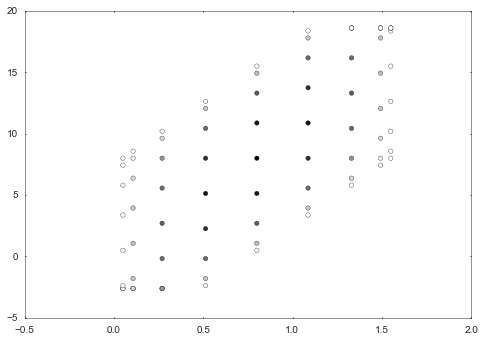

In [49]:
M = 7
P = cp.orth_ttr(M,dist_R)
nodes_R, weights_R = cp.generate_quadrature(M+1, dist_R)
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) #tr(nodes_R)  #
#weights_Q = weights_R*dist_Q.pdf(nodes_Q)/dist_R.pdf(nodes_R)

sample_u_pc = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_pc)
plt.scatter(nodes_Q[0,:],nodes_Q[1,:],c=weights_R)
print len(weights_R)

In [50]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

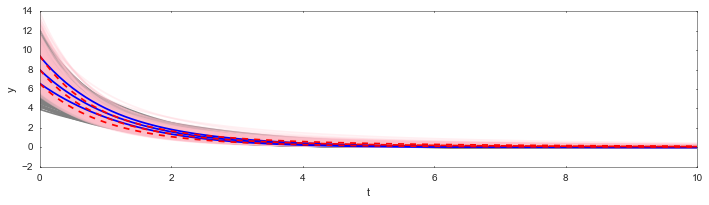

In [51]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()

print

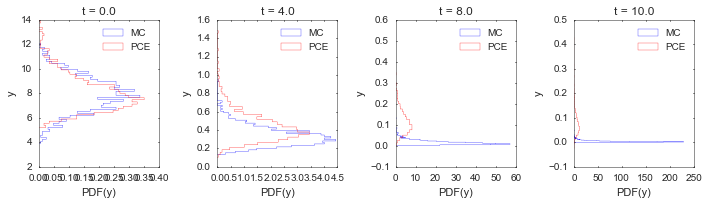

In [52]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
    fig.tight_layout()
print

### d) Conclusion

PCE with spectral collocation does not work for correlated variables, becuase the correlation is NOT considered in the quadrature rule. 

PCE with point collocation and a simple least square polynomial fit DOES work. 

# 4) Multivariate with Rosemblat

In [53]:
def u(x,a,I):
    return I*np.exp(-a*x)

x = np.linspace(0,10,101)

In [54]:
dist_a = cp.Uniform(.6,.8)
dist_I = cp.Weibull(shape=2., scale=(0.3+dist_a)**4.*6., shift=0)
dist_Q = cp.J(dist_a, dist_I)
dist_R = cp.J(cp.Uniform(),cp.Uniform())

### a) Full MC with Halton sampling

In [55]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

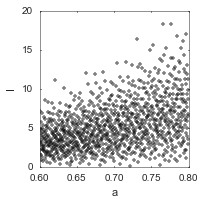

In [56]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
#fig.savefig('Figures/4_Rosenblatt_MC_sample.pdf')
print

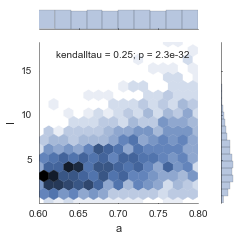

In [57]:
fig=sns.jointplot(sample_inputs[0,:],
              sample_inputs[1,:], 
              kind="hex", 
              stat_func=stats.kendalltau,
              size=3.5
             )

fig.set_axis_labels('a','I')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_MC_sample_joint.pdf')
print


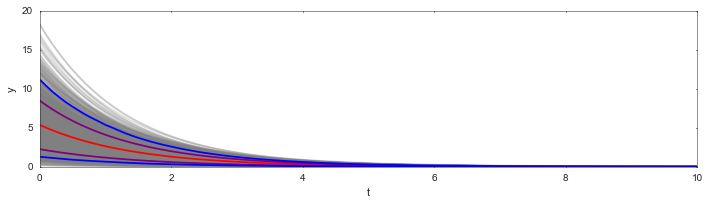

In [58]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_MC.pdf')
print

### b) Point collocation: Least squares

In [59]:
M = 5     # Order of the polynomial
N = M + 1 # Number of terms

In [60]:
P = cp.orth_ttr(M,dist_R)
# Exponenial rule
nodes_R = dist_R.sample(2**M-1,rule='M') #
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)

31


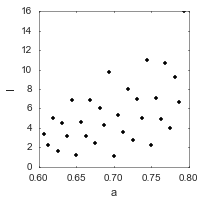

In [61]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.k')

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_PCE_sample.pdf')
print len(nodes_Q[0,:])

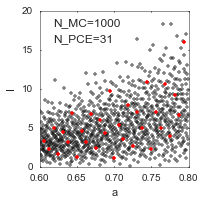

In [62]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.62,18,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.62,16,'N_PCE='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_MC_sample.pdf')
print

In [63]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

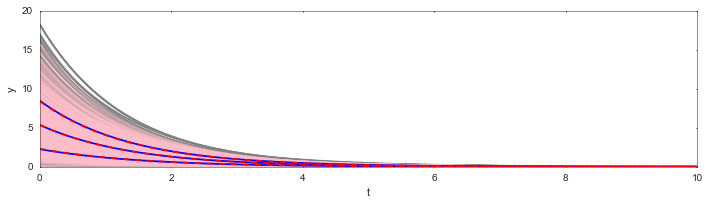

In [64]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

#ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_top.pdf')
print

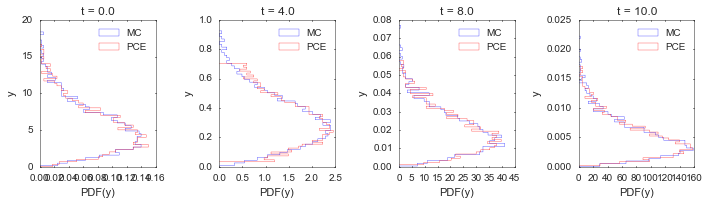

In [65]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_bot.pdf')
print

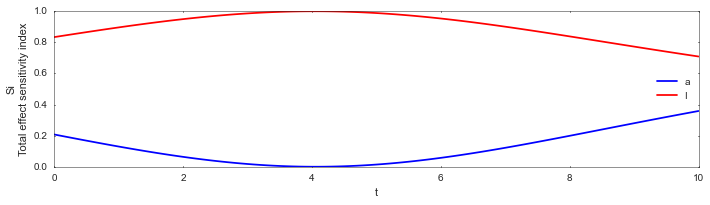

In [66]:
Sensitivity = cp.Sens_t(u_hat, dist_R)

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/4_Rosenblatt_Sens.pdf')



# 5) Multivariate with Rosemblat and couplas

In [67]:
dist_a = cp.Normal(.8,.2)#cp.Uniform(.6,.8)
dist_I = cp.Weibull(shape=2., scale=2., shift=0) + 4.
dist = cp.J(dist_a, dist_I)
#dist_Q = cp.Clayton(dist, theta=2.)
#dist_Q = cp.Copula(dist, cp.gumbel(len(dist), theta=2.) ) ## dist_Q = cp.Gumbel(dist, theta=2.) ## Does not work
dist_Q = cp.Joe(dist, theta=5.)
dist_R = cp.J(cp.Uniform(),cp.Uniform())

### a) Full MC with Halton sampling

In [68]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([u(x,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

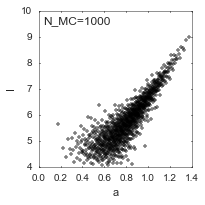

In [69]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.05,9.5,'N_MC='+str(len(sample_inputs[0,:])))

fig.tight_layout()
#fig.savefig('Figures/5_Joe_copula_MC_sample.pdf')
print

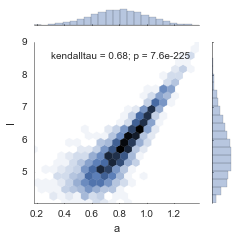

In [70]:
fig=sns.jointplot(sample_inputs[0,:],
              sample_inputs[1,:], 
              kind="hex", 
              stat_func=stats.kendalltau,
              size=3.5
             )

fig.set_axis_labels('a','I')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_MC_sample_joint.pdf')
print

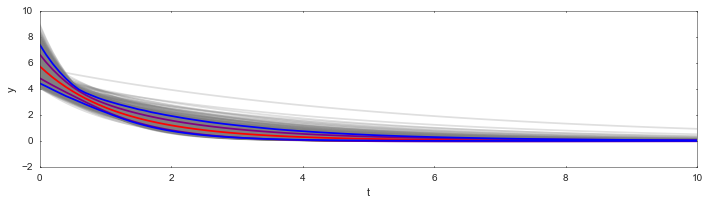

In [71]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey',alpha=0.25)
ax.plot(x,E_u,'r')
ax.plot(x,E_u+Std_u,'purple')
ax.plot(x,E_u-Std_u,'purple')
ax.plot(x,Q05_u,'blue')
ax.plot(x,Q95_u,'blue')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_MC.pdf')
print

### b) Point collocation: Least squares

In [72]:
M = 5     # Order of the polynomial
N = M + 1 # Number of terms

In [73]:
P = cp.orth_ttr(M,dist_R)
# Exponenial rule
nodes_R = dist_R.sample(2**M-1,rule='M') #
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)

31


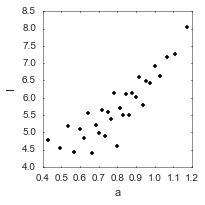

In [74]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)

plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.k')

ax.set_xlabel('a')
ax.set_ylabel('I')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_PCE_sample.pdf')
print len(nodes_Q[0,:])

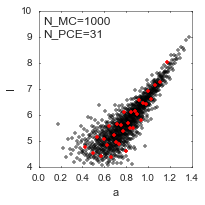

In [75]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
plt.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.05,9.5,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.05,9,'N_PCE='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_MC_sample.pdf')
print

 q0, q1
[1515, 1515]

(101, 21)
(1, 0) -0.564735246637
(2, 0) 2.62447680632
(4, 0) 5.51586668252
(5, 0) -1.9931203935
(0, 1) 0.00162729578827
(1, 2) -0.196895863949
(3, 2) 0.801266154438
(0, 0) 0.0548491145904
(3, 0) -5.65896478784
(1, 1) -0.723193175159
(2, 1) 2.06178253807
(3, 1) -1.49155954965
(4, 1) 0.328033097112
(0, 2) 0.435771495225
(2, 2) -1.77803166334
(1, 3) 1.72792951574
(2, 3) 0.26629452183
(0, 3) -0.775886088186
(1, 4) -1.00865900191
(0, 4) 0.212509711529
(0, 5) 0.158416218456


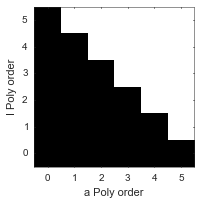

In [76]:
print ' q0, q1'
print [str(u_hat).count(q) for q in ['q0','q1']]
print 
print u_hat.coeffs().shape
for i in range(len(u_hat.expons())):
    print u_hat.expons()[i], u_hat.coeffs()[100,i]
    
A=np.zeros([M+1,M+1])
for i in range(len(u_hat.expons())):
    A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.imshow(A[:,:], interpolation='nearest',origin='lower')
ax.set_xlabel('a Poly order')
ax.set_ylabel('I Poly order')
fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_PCE_sparse.pdf')

In [77]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

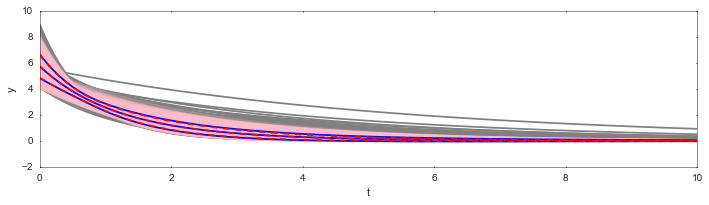

In [78]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

#ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_top.pdf')
print

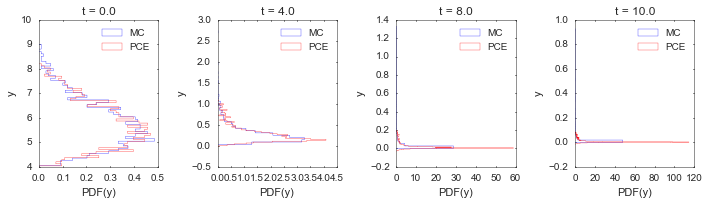

In [79]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_bot.pdf')
print

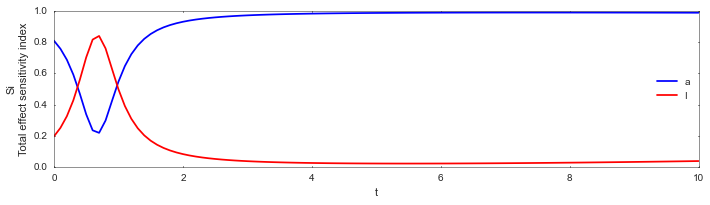

In [80]:
Sensitivity = cp.Sens_t(u_hat, dist_R)

fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)
ax.plot(x,Sensitivity[0,:],'blue',label='a')
ax.plot(x,Sensitivity[1,:],'red',label='I')
ax.legend(loc='center right')

ax.set_xlabel('t')
ax.set_ylabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/5_Joe_copula_Sens.pdf')

# 6) Multivariate pdf: with Rosemblat and couplas
## Only one output or quantity of interest (QoI)

ISHIGAMI FUNCTION

Description: $ y = \sin(x_1) + a\,\sin^2(x_2) + b\,x_3^4 \,\sin(x_1) $

Dimensions: 3 

The Ishigami function of Ishigami & Homma (1990) is used as an example for uncertainty and sensitivity analysis methods, because it exhibits strong nonlinearity and nonmonotonicity. It also has a peculiar dependence on x3, as described by Sobol' & Levitan (1999). 

The values of a and b used by Crestaux et al. (2007) and Marrel et al. (2009) are: a = 7 and b = 0.1. Sobol' & Levitan (1999) use a = 7 and b = 0.05. 


In [82]:
def ishigami(a,b,x1,x2,x3):
    term1 = np.sin(x1)
    term2 = a*(np.sin(x2))**2
    term3 = b*x3**4. * np.sin(x1)

    return term1 + term2 + term3

a = 7.
b = 0.8#0.1

In [83]:
dist_x1 = cp.Uniform(-np.pi,np.pi)
dist_x2 = cp.Uniform(-np.pi,np.pi)
dist_x3 = cp.Uniform(-np.pi,np.pi)

dist = cp.J(dist_x1,dist_x2,dist_x3)
dist_Q = cp.Joe(dist, theta=1.)#6.)
dist_R = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform())

### a) MC with Halton sampling

In [84]:
sample_inputs = dist_Q.sample(size=1000,rule='H')
sample_u = np.array([ishigami(a,b,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

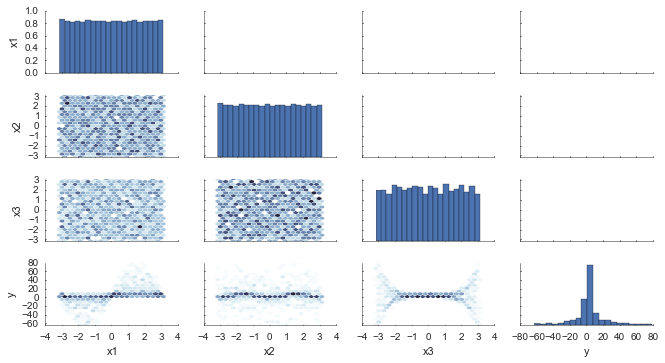

In [89]:
g=sns.PairGrid(pd.DataFrame(columns=['x1','x2','x3','y'],data=np.vstack([sample_inputs,sample_u]).T),
               size=1.3,aspect=1.8,diag_sharey=False)
#g.map_lower(plt.scatter,alpha=0.2)
g.map_lower(plt.hexbin, gridsize=20, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
g.map_diag(plt.hist,bins=20) 
g.savefig('Figures/6_Ishigami_MC_sample.pdf')

### b) PCE with Point collocation

In [90]:
M = 8    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_R)

In [91]:
# Fixed number of model evaluations and Hammersley sequence sampling
nodes_R = dist_R.sample(100,rule='M')

# Exponenial rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2**M-1,rule='M')

# Linear rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2*M-1,rule='M')

print 'nodes', len(nodes_R[0,:])

nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = np.array([ishigami(a,b,*node) for node in nodes_Q.T])

nodes 100


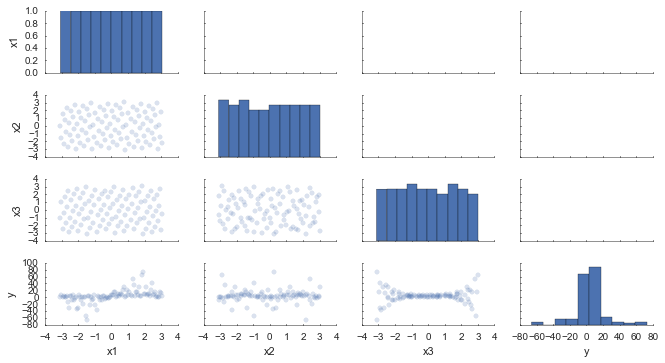

In [92]:
g=sns.PairGrid(pd.DataFrame(columns=['x1','x2','x3','y'],data=np.vstack([nodes_Q,sample_u_pc]).T),
               size=1.3,aspect=1.8,diag_sharey=False)
g.map_lower(plt.scatter,alpha=0.2)
#g.map_lower(plt.hexbin, gridsize=40, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist) 
g.savefig('Figures/6_Ishigami_PCE_nodes.pdf')

60
(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(5, 0, 0)
(6, 0, 0)
(1, 1, 0)
(2, 1, 0)
(3, 1, 0)
(4, 1, 0)
(0, 1, 0)
(0, 2, 0)
(1, 2, 0)
(2, 2, 0)
(3, 2, 0)
(1, 3, 0)
(2, 3, 0)
(0, 3, 0)
(0, 4, 0)
(0, 5, 0)
(0, 6, 0)
(1, 0, 1)
(2, 0, 1)
(3, 0, 1)
(4, 0, 1)
(0, 1, 1)
(1, 1, 1)
(2, 1, 1)
(3, 1, 1)
(4, 1, 1)
(0, 2, 1)
(1, 2, 1)
(1, 3, 1)
(2, 3, 1)
(0, 0, 1)
(2, 2, 1)
(0, 3, 1)
(0, 4, 1)
(1, 0, 2)
(2, 0, 2)
(3, 0, 2)
(0, 1, 2)
(1, 1, 2)
(0, 2, 2)
(0, 3, 2)
(0, 0, 2)
(1, 2, 2)
(0, 4, 2)
(1, 0, 3)
(2, 0, 3)
(0, 1, 3)
(1, 1, 3)
(0, 2, 3)
(0, 0, 3)
(1, 0, 4)
(0, 0, 4)
(0, 1, 4)
(0, 0, 5)
(0, 0, 0)
(0, 1, 5)


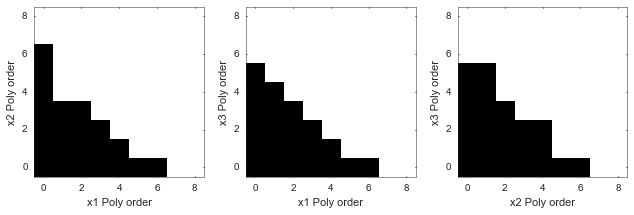

In [93]:
# Point collocation
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc, 
                          #rule='LA',n_nonzero_coefs=20) #Lars (Least Angle Regression). n_nonzero_coefs= all dimensions
                          #rule='LAS',alpha=1e-4,max_iter=200) #Lasso (Least Absolute Shrinkage and Selection Operator) 
                          rule='LL', alpha=1e-4,max_iter=200) #Lasso and Lars model
                          #rule='OMP',n_nonzero_coefs=M+1, tol=1e2) # Orthogonal Matching Pursuit. n_nonzero_coefs=1D
                          # -----------
                          # NOT sparse
                          # -----------
                          #rule='BARD')

# Statistics based on the PCE coefficients
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

print len(u_hat.expons())
for i in range(len(u_hat.expons())):
    print u_hat.expons()[i]#, u_hat.coeffs()[i]

A=np.zeros([M+1,M+1,M+1])
for i in range(len(u_hat.expons())):
    A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[9,3])

ax = fig.add_subplot(131)
plt.imshow(A[:,:,0].T, 
           interpolation='nearest',
           origin='lower'
          )
           #cmap=plt.cm.RdBu,
           #vmin=-np.max(u_hat.coeffs()),
           #vmax=np.max(u_hat.coeffs()))
ax.set_xlabel('x1 Poly order')
ax.set_ylabel('x2 Poly order')

ax = fig.add_subplot(132)
plt.imshow(A[:,0,:].T, 
           interpolation='nearest',
           origin='lower'
          )
           #cmap=plt.cm.RdBu,
           #vmin=-np.max(u_hat.coeffs()),
           #vmax=np.max(u_hat.coeffs()))
ax.set_xlabel('x1 Poly order')
ax.set_ylabel('x3 Poly order')

ax = fig.add_subplot(133)
plt.imshow(A[0,:,:].T, 
           interpolation='nearest',
           origin='lower'
          )
           #cmap=plt.cm.RdBu,
           #vmin=-np.max(u_hat.coeffs()),
           #vmax=np.max(u_hat.coeffs()))
ax.set_xlabel('x2 Poly order')
ax.set_ylabel('x3 Poly order')

fig.tight_layout()
fig.savefig('Figures/6_Ishigami_PCE_sparse.pdf')          

In [94]:
# Repeat the MC sample ussing the surrogate model
sample_R_inputs = dist_R.sample(size=1000,rule='H')
sample_Q_inputs = dist_Q.inv(dist_R.fwd(sample_R_inputs))
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_R_inputs.T ])

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

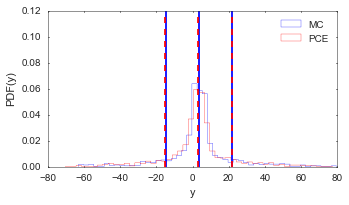

In [95]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,0.12,'blue')
#plt.vlines([Q05_u,Q95_u],0,0.12,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE'
        )
plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,0.12,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,0.12,'pink')

ax.set_xlabel('y')
ax.set_ylabel('PDF(y)')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/6_Ishigami_PCE_y.pdf')
print

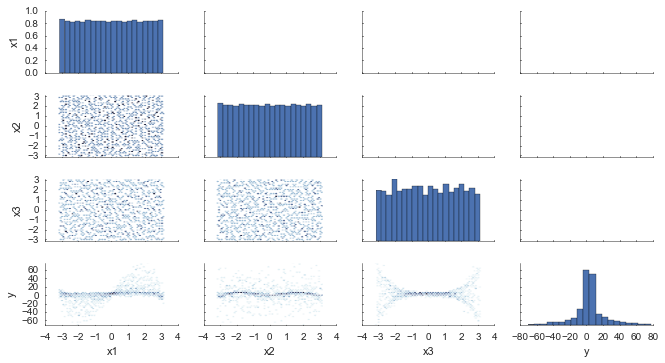

In [96]:
g=sns.PairGrid(pd.DataFrame(columns=['x1','x2','x3','y'],data=np.vstack([sample_Q_inputs,sample_u_hat]).T),
               size=1.3,aspect=1.8,diag_sharey=False)
#g.map_lower(plt.scatter,alpha=0.2)
g.map_lower(plt.hexbin, gridsize=40, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist,bins=20) 
g.savefig('Figures/6_Ishigami_PCE_sample.pdf')

# 7) Joint distribution for wind energy

Analytical power model for testing

In [3]:
def model(WD,WS,sigma_WS,shear):
    CP = 0.45
    rho = 1.225
    D = 70.
    A = np.pi*D**2/4
    WS_rated = 15.
    P_rated = 3.6e6
    
    TI = sigma_WS/WS
    CP_TI = CP*( 1./(TI+1.) )*( 0.5*special.erf( 3. - (1.*WS/WS_rated) ) + 0.5 )
    WS_eq = WS*( (TI+1.)**3. ) * ( 1. - 0.15*np.cos( shear*np.pi/0.4 ) )
    
    P = CP_TI*0.5*rho*A*(WS_eq)**3.*( 1. - 0.6*np.cos( np.deg2rad(WD) )**8. )
    return (P/P_rated)*(P<P_rated)*(P>3.) + (1.)*(P>=P_rated) + 0.*(P<=3.)



Joint probability in wind energy [1]

[1] Dimitrov, N., Natarajan, A., & Kelly, M. (2015). Model of wind shear conditional on turbulence and its impact on wind turbine loads. Wind Energy, 18(11), 1917-1931.

In [4]:
dist_WD = cp.Uniform(0.,360.)
dist_WS = cp.Weibull(shape=2., scale=8.5)
TI_ref = .14
dist_sigma_WS = cp.Lognormal(scale=TI_ref*(0.75*dist_WS + 3.8), 
                             sigma=1.4*TI_ref)
shear_ref = 0.2
dist_shear = cp.Normal(mu=(0.15+shear_ref*TI_ref + (TI_ref - dist_sigma_WS/dist_WS)/(4*dist_sigma_WS/dist_WS)),
                       sigma=1./dist_WS)

dist_Q = cp.J(dist_WD,dist_WS,dist_sigma_WS,dist_shear)
dist_R = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform(),cp.Uniform())

### A) Full MC with Halton sampling

In [5]:
sample_inputs = dist_Q.sample(size=10000,rule='H')
sample_u = model(*sample_inputs)

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

df_sample = pd.DataFrame(
    columns=['WD','WS','sigma_WS','shear'],
    #columns=['WS','sigma_WS'],
    data = sample_inputs.T)
df_sample['TI']=df_sample.sigma_WS/df_sample.WS
df_sample['P'] = sample_u

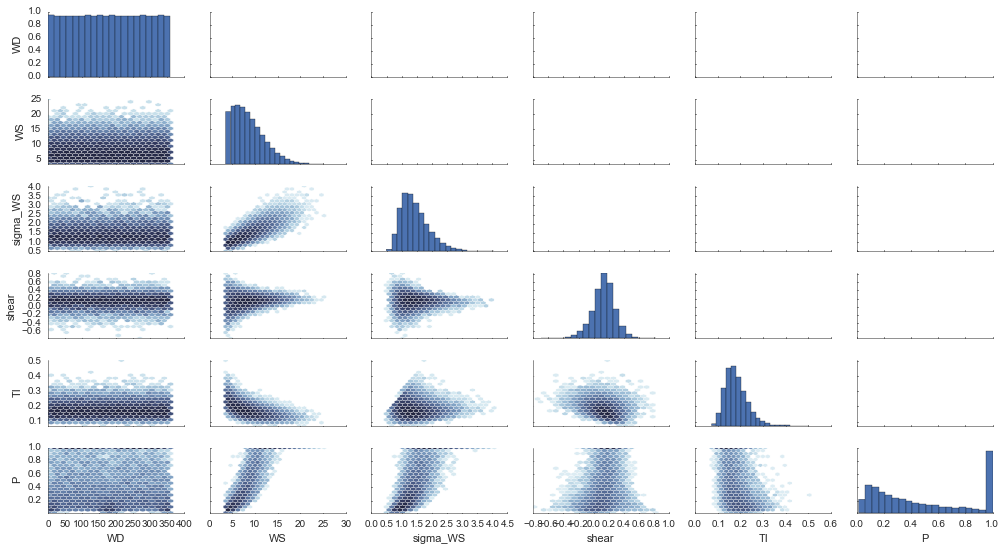

In [6]:
g = sns.PairGrid(df_sample[df_sample.WS>3.5],diag_sharey=False,size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20) 
g.savefig('Figures/7_WindEnergy_MC_sample.pdf')

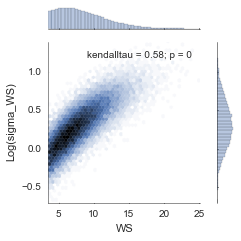

In [7]:
fig=sns.jointplot(df_sample[df_sample.WS>3.5].WS,
              np.log(df_sample[df_sample.WS>3.5].sigma_WS),
              kind="hex", 
              stat_func=stats.kendalltau,
              size=3.5
             )
fig.set_axis_labels('WS','Log(sigma_WS)')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('Figures/7_WindEnergy_MC_sample_WS_Log_sigma.pdf')
print

In [8]:
print df_sample[(df_sample.WS>14.5)&(df_sample.WS<15.5)].TI.mean()
print df_sample[(df_sample.WS>14.5)&(df_sample.WS<15.5)].sigma_WS.mean()

0.142658417965
2.13601797456


In [9]:
print df_sample.shear.mean()
print df_sample[(df_sample.WS>14.5)&(df_sample.WS<15.5)].shear.mean()

0.117832587626
0.183627992579


### b) PCE with point collocation

In [10]:
M = 10    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_R)

In [11]:
# Fixed number of model evaluations and Hammersley sequence sampling
nodes_R = dist_R.sample(100,rule='M')
#nodes_R = dist_R.sample(200,rule='M')

# Exponenial rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2**M-1,rule='M')

# Linear rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2*M-1,rule='M')

print 'nodes', len(nodes_R[0,:])

nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = np.array([model(*node) for node in nodes_Q.T])

df_nodes = pd.DataFrame(
    columns=['WD','WS','sigma_WS','shear'],
    #columns=['WS','sigma_WS'],
    data = nodes_Q.T)
df_nodes['TI']=df_nodes.sigma_WS/df_nodes.WS
df_nodes['P'] = sample_u_pc

nodes 100


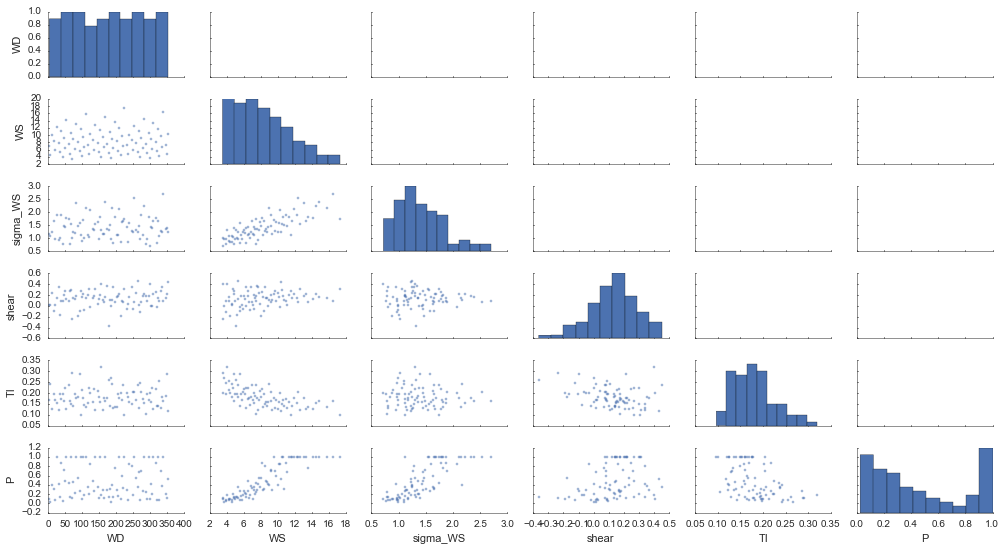

In [12]:
g = sns.PairGrid(df_nodes[df_nodes.WS>3.5],diag_sharey=False,size=1.3,aspect=1.8)
g.map_lower(plt.scatter,alpha=0.5, marker='.')#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)        
g.savefig('Figures/7_WindEnergy_PCE_nodes.pdf')

In [20]:
print nodes_R.shape
print type(nodes_R)
print
print sample_u_pc.shape
print type(sample_u_pc)

(4, 100)
<type 'numpy.ndarray'>

(100,)
<type 'numpy.ndarray'>


1001


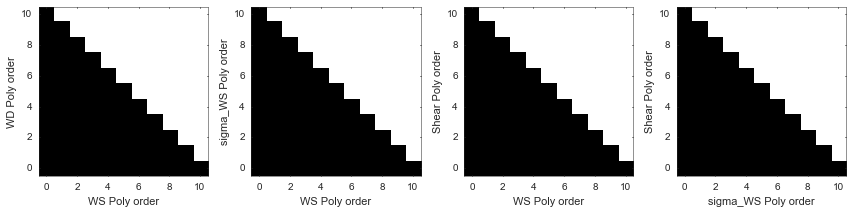

In [16]:
# Point collocation
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)#, 
                          #rule='LA',n_nonzero_coefs=100) #Lars (Least Angle Regression). n_nonzero_coefs= all dimensions
                          #rule='LAS',alpha=1e-4,max_iter=200) #Lasso (Least Absolute Shrinkage and Selection Operator) 
                          #rule='LL', alpha=1e-4,max_iter=200) #Lasso and Lars model
                          #rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='OMP',n_nonzero_coefs=M+1, tol=1e2) # Orthogonal Matching Pursuit. n_nonzero_coefs=1D
                          # -----------
                          # NOT sparse
                          # -----------
                          #rule='BARD')

# Statistics based on the PCE coefficients
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

print len(u_hat.expons())
if len(u_hat.expons())<100:
    for i in range(len(u_hat.expons())):
        print u_hat.expons()[i]#, u_hat.coeffs()[i]

A=np.zeros([M+1,M+1,M+1,M+1])
for i in range(len(u_hat.expons())):
    A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(141)
plt.imshow(A[:,:,0,0], 
           interpolation='nearest',
           origin='lower'
          )
ax.set_ylabel('WD Poly order')
ax.set_xlabel('WS Poly order')

ax = fig.add_subplot(142)
plt.imshow(A[0,:,:,0].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('sigma_WS Poly order')

ax = fig.add_subplot(143)
plt.imshow(A[0,:,0,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('Shear Poly order')

ax = fig.add_subplot(144)
plt.imshow(A[0,0,:,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('sigma_WS Poly order')
ax.set_ylabel('Shear Poly order')

fig.tight_layout()
fig.savefig('Figures/7_WindEnergy_PCE_sparse.pdf')

In [21]:
# Repeat the MC sample ussing the surrogate model
sample_R_inputs = dist_R.sample(size=10000,rule='H')
sample_Q_inputs = dist_Q.inv(dist_R.fwd(sample_R_inputs))
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_R_inputs.T ])

# Do NOT truncate the surrogate to show the rated power.
# You will loose the accuracy in E and V
#sample_u_hat = sample_u_hat*(sample_u_hat<=1.)*(sample_u_hat>0.) + 1.*(sample_u_hat>1.)

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

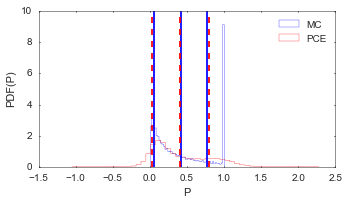

In [22]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,10,'blue')
#plt.vlines([Q05_u,Q95_u],0,10,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE'
        )
plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,10,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,10,'pink')

ax.set_xlabel('P')
ax.set_ylabel('PDF(P)')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/7_WindEnergy_PCE_P.pdf')
print

In [23]:
df_sample_pc = pd.DataFrame(
    columns=['WD','WS','sigma_WS','shear'],
    #columns=['WS','sigma_WS'],
    data = sample_Q_inputs.T)
df_sample_pc['TI']=df_sample_pc.sigma_WS/df_sample_pc.WS
df_sample_pc['P'] = sample_u_hat

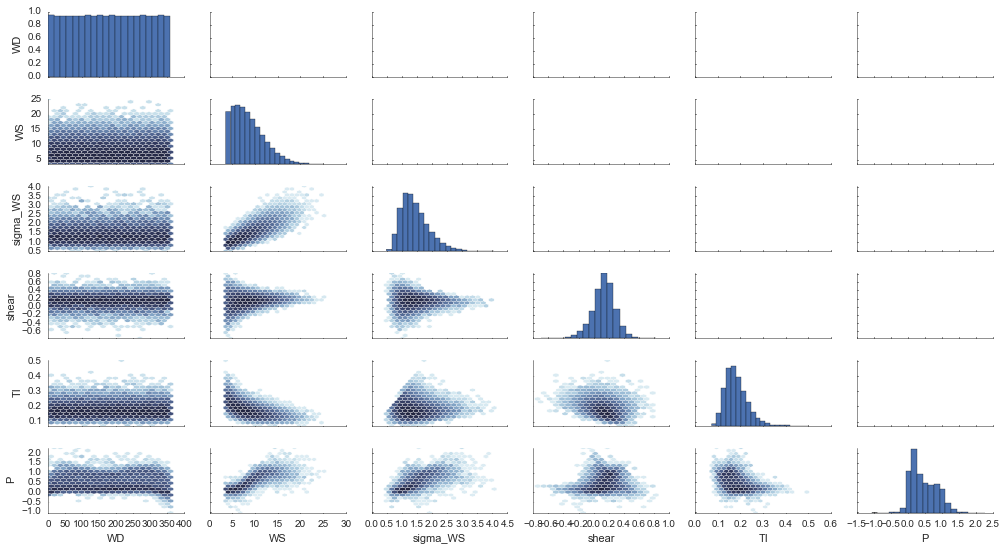

In [24]:
g = sns.PairGrid(df_sample_pc[df_sample_pc.WS>3.5],diag_sharey=False, size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20)
g.savefig('Figures/7_WindEnergy_PCE_sample.pdf')

# 8) Joint distribution for wind energy with truncated Weibull

In [36]:
def model(WS,sigma_WS,shear):
    CP = 0.45
    rho = 1.225
    D = 70.
    A = np.pi*D**2/4
    WS_rated = 15.
    P_rated = 3.6e6
    
    TI = sigma_WS/WS
    CP_TI = CP*( 1./(TI+1.) )*( 0.5*special.erf( 3. - (1.*WS/WS_rated) ) + 0.5 )
    WS_eq = WS*( (TI+1.)**3. ) * ( 1. - 0.15*np.cos( shear*np.pi/0.4 ) )
    
    P = CP_TI*0.5*rho*A*(WS_eq)**3.
    return (P/P_rated)*(P<P_rated)*(P>3.) + (1.)*(P>=P_rated) + 0.*(P<=3.)


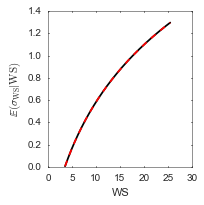

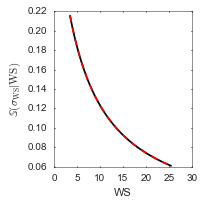

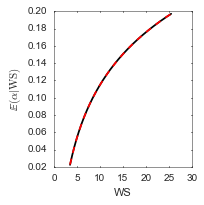

In [37]:
WS_rng = np.linspace(3.5,25.5,1000,endpoint=True)
I_ref = .16
S_sigma = (np.log( 1. + (1.4)**2./(0.75*WS_rng + 3.8)**2.))**0.5
E_sigma = np.log( I_ref*(0.75*WS_rng + 3.8) ) - S_sigma**2./2

E_sigma_pfit = np.poly1d(np.polyfit(WS_rng,E_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,E_sigma,'k')
ax.plot(WS_rng,E_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

S_sigma_pfit = np.poly1d(np.polyfit(WS_rng,S_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,S_sigma,'k')
ax.plot(WS_rng,S_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{S}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

mu_shear = 0.088*(np.log(WS_rng)-1.)

E_a = np.poly1d(np.polyfit(WS_rng,mu_shear,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,mu_shear,'k')
ax.plot(WS_rng,E_a(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\alpha|\mathrm{WS})$')
fig.tight_layout()




### 0) Joint distribution 

In [38]:
Weibull_truncated = cp.construct(
     cdf=lambda self,q,shape,scale,inf,sup: (stats.weibull_min.cdf(q,shape,scale=scale)\
                                             -stats.weibull_min.cdf(inf,shape,scale=scale))/\
                                            (stats.weibull_min.cdf(sup,shape,scale=scale)\
                                             -stats.weibull_min.cdf(inf,shape,scale=scale)),
     bnd=lambda self,shape,scale,inf,sup: (inf,sup),
     #pdf=lambda self,q,shape,scale,inf,sup: stats.vonmises.pdf(q,shape,scale=scale),
     #ppf=lambda self,u,shape,scale,inf,sup: stats.vonmises.ppf(u,shape,scale=scale),
     #mom=lambda self,k,shape,scale,inf,sup: stats.vonmises.moment(k,shape,scale=scale),
     defaults=dict(shape=2., scale=1.,inf=3.5,sup=25.5),
     str=lambda self,shape,scale,inf,sup: ("W_tr%s%s%s%s" % (shape, scale,inf,sup)))

In [39]:
#dist_WS = cp.Weibull(shape=2., scale=10./special.gamma(1.+1./2.))
dist_WS = Weibull_truncated(shape=2., scale=10./special.gamma(1.+1./2.),inf=3.5,sup=25.)
TI_ref = .16
dist_sigma_WS = cp.Lognormal(mu=E_sigma_pfit(dist_WS), sigma=S_sigma_pfit(dist_WS))
dist_shear = cp.Normal(mu=E_a(dist_WS),sigma=1./dist_WS)

dist_Q = cp.J(dist_WS,dist_sigma_WS,dist_shear)
dist_R = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform())

### A) Full MC with Halton sampling


In [40]:
sample_inputs = dist_Q.sample(size=10000,rule='H')
sample_u = model(*sample_inputs)

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

df_sample = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_inputs.T)
df_sample['TI']=df_sample.sigma_WS/df_sample.WS
df_sample['P'] = sample_u

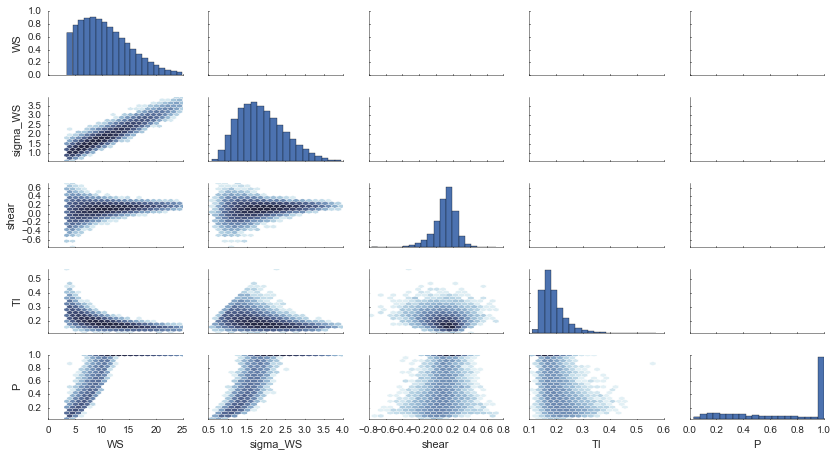

In [41]:
g = sns.PairGrid(df_sample,diag_sharey=False,size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20) 
g.savefig('Figures/8_WindEnergy_MC_sample.pdf')

### B) PCE expansion

In [42]:
M = 10    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_R)

In [45]:
# Fixed number of model evaluations and Hammersley sequence sampling
nodes_R = dist_R.sample(100,rule='M')
#nodes_R = dist_R.sample(200,rule='M')

# Exponenial rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2**M-1,rule='M')

# Linear rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2*M-1,rule='M')

print 'nodes', len(nodes_R[0,:])

nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = np.array([model(*node) for node in nodes_Q.T])

df_nodes = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = nodes_Q.T)
df_nodes['TI']=df_nodes.sigma_WS/df_nodes.WS
df_nodes['P'] = sample_u_pc

nodes 100


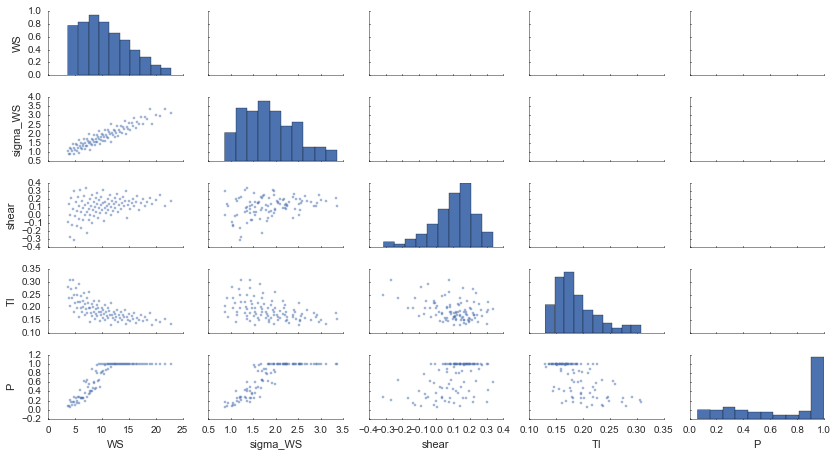

In [51]:
g = sns.PairGrid(df_nodes,diag_sharey=False,size=1.3,aspect=1.8)
g.map_lower(plt.scatter,alpha=0.5, marker='.')#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)        
g.savefig('Figures/8_WindEnergy_PCE_nodes.pdf')

36
(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(5, 0, 0)
(1, 1, 0)
(2, 1, 0)
(3, 1, 0)
(0, 1, 0)
(0, 2, 0)
(1, 2, 0)
(1, 3, 0)
(0, 3, 0)
(0, 4, 0)
(1, 0, 1)
(2, 0, 1)
(3, 0, 1)
(4, 0, 1)
(0, 1, 1)
(1, 1, 1)
(0, 2, 1)
(0, 0, 1)
(2, 1, 1)
(0, 3, 1)
(1, 0, 2)
(2, 0, 2)
(3, 0, 2)
(0, 1, 2)
(1, 1, 2)
(0, 2, 2)
(0, 0, 2)
(1, 0, 3)
(0, 0, 3)
(0, 0, 4)
(0, 0, 0)
(0, 1, 3)


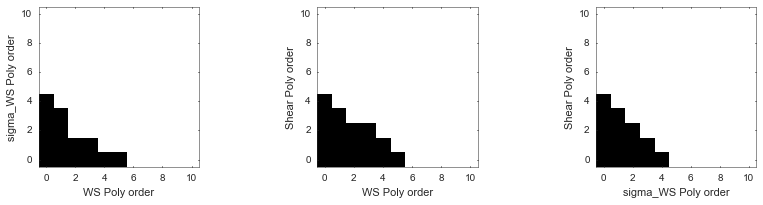

In [57]:
# Point collocation
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc, 
                          #rule='LA',n_nonzero_coefs=100) #Lars (Least Angle Regression). n_nonzero_coefs= all dimensions
                          #rule='LAS',alpha=1e-4,max_iter=200) #Lasso (Least Absolute Shrinkage and Selection Operator) 
                          rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='OMP',n_nonzero_coefs=M+1, tol=1e2) # Orthogonal Matching Pursuit. n_nonzero_coefs=1D
                          # -----------
                          # NOT sparse
                          # -----------
                          #rule='BARD')

# Statistics based on the PCE coefficients
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

print len(u_hat.expons())
if len(u_hat.expons())<100:
    for i in range(len(u_hat.expons())):
        print u_hat.expons()[i]#, u_hat.coeffs()[i]

A=np.zeros([M+1]*3)
for i in range(len(u_hat.expons())):
    A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(131)
plt.imshow(A[:,:,0].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('sigma_WS Poly order')

ax = fig.add_subplot(132)
plt.imshow(A[:,0,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('Shear Poly order')

ax = fig.add_subplot(133)
plt.imshow(A[0,:,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('sigma_WS Poly order')
ax.set_ylabel('Shear Poly order')

fig.tight_layout()
fig.savefig('Figures/8_WindEnergy_PCE_sparse.pdf')

In [64]:
# Repeat the MC sample ussing the surrogate model
sample_R_inputs = dist_R.sample(size=10000,rule='H')
sample_Q_inputs = dist_Q.inv(dist_R.fwd(sample_R_inputs))
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_R_inputs.T ])

# Do NOT truncate the surrogate to show the rated power.
# You will loose the accuracy in E and V
# sample_u_hat = sample_u_hat*(sample_u_hat<=1.)*(sample_u_hat>0.) + 1.*(sample_u_hat>1.)

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

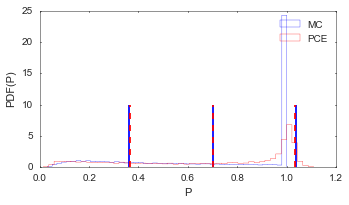

In [65]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,10,'blue')
#plt.vlines([Q05_u,Q95_u],0,10,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE'
        )
plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,10,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,10,'pink')

ax.set_xlabel('P')
ax.set_ylabel('PDF(P)')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/8_WindEnergy_PCE_P.pdf')
print

In [66]:
df_sample_pc = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_Q_inputs.T)
df_sample_pc['TI']=df_sample_pc.sigma_WS/df_sample_pc.WS
df_sample_pc['P'] = sample_u_hat

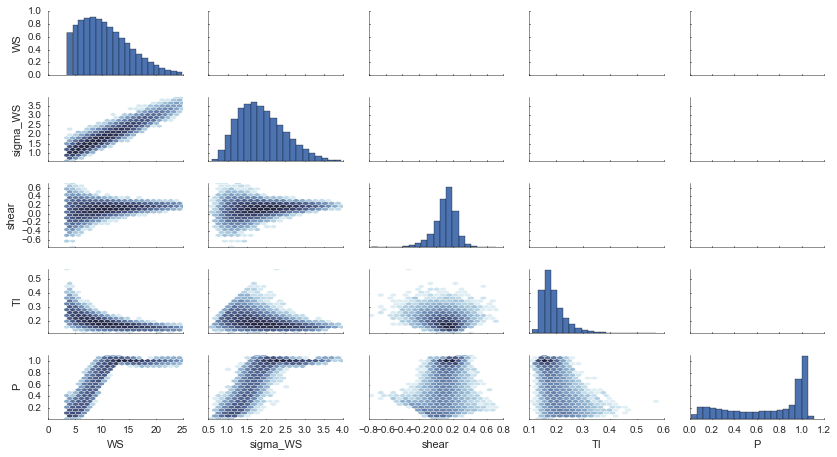

In [67]:
g = sns.PairGrid(df_sample_pc,diag_sharey=False, size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20)
g.savefig('Figures/8_WindEnergy_PCE_sample.pdf')